In [1]:
import os, time
import numpy as np
import pickle

# RNN model and task
from model import RNN, run_net
from task_generators import input_driven_fp
task_generator = input_driven_fp

# Figures 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import style
from fig_specs import *
save_fig=True

# Data directory 
from data_dir import data_dir
data_file_name = "linear_zhats_gs_N_1024_tmax_101.pkl"
data_file = os.path.join(data_dir, data_file_name)

In [2]:
# Load data
with open(data_file, 'rb') as handle:
    res_dict = pickle.load(handle)
print("Loaded data from " + data_file)

dims = res_dict["dims"]
dt = res_dict["dt"]
noise_std = res_dict["noise_std"]
n_epochs = res_dict["n_epochs"]
rec_step = res_dict["rec_step"]
epochs = res_dict["epochs"]
rec_epochs = res_dict["rec_epochs"]
gs = res_dict["gs"]
target_amps = res_dict["target_amps"]
lr0s = res_dict["lr0s"]
n_gs = res_dict["n_gs"]
n_tas = res_dict["n_tas"]
n_samples = res_dict["n_samples"]
lrs_all = res_dict["lrs_all"]
tls_all = res_dict["tls_all"]
task_params_all = res_dict["task_params_all"]
wi_init_all = res_dict["wi_init_all"]
wo_init_all = res_dict["wo_init_all"]
wrec_init_all = res_dict["wrec_init_all"]
dwrec_last_all = res_dict["dwrec_last_all"]
losses_all = res_dict["losses_all"]
grad_norms_all = res_dict["grad_norms_all"]
loss_shuff_all = res_dict["loss_shuff_all"]
ev_w_all = res_dict["ev_w_all"]
sv_dw_all = res_dict["sv_dw_all"]
zs_all = res_dict["zs_all"]
time_t = res_dict["time_t"]
time_ev = res_dict["time_ev"]
time_sv = res_dict["time_sv"]
time_ls = res_dict["time_ls"]
    
dim_in, dim_rec, dim_out = dims
# Nonlinearity
nonlinearity = 'id'

In [3]:
# Learning time and gradient norms
tl_cs_all = np.zeros((n_samples, n_tas, n_gs))
idx_c_all = np.zeros((n_samples, n_tas, n_gs), dtype=int)
avg_grad_norms_all = np.zeros((n_samples, n_tas, n_gs))
for k in range(n_samples):
    for j, target_amp in enumerate(target_amps):
        loss_0 = target_amp**2 / 2
        loss_c = rel_loss_c * loss_0
        for i, g in enumerate(gs):
            losses = losses_all[k, j, i]
            tls = tls_all[j, i]
            idx_c = np.argmax(losses < loss_c, axis=-1)
            tl_cs = tls[idx_c]
            
            # Average of gradient norm over learning time
            dtl = tls[1] - tls[0]
            grad_norms = grad_norms_all[k, j, i] * dtl
            # Only up to convergence
            avg_grad_norms = grad_norms[:idx_c].sum() / tl_cs
            
            # Save
            idx_c_all[k, j, i] = idx_c
            tl_cs_all[k, j, i] = tl_cs
            avg_grad_norms_all[k, j, i] = avg_grad_norms
            
# Norm of weight matrix at the end of learning
norm_dw_last_all = np.sqrt(np.sum(sv_dw_all[:, :, :, -1]**2, axis=-1))

In [4]:
#########################################################################################3
# Analytical theory
# Cut theory at z - z_hat ?
cut_theo = True

# Compute analytical theory for a dense array for gs
assert gs[0] == 0
g_theo_max = 0.95
dg_theo = 0.01
gs_theo = np.arange(0, g_theo_max+dg_theo, dg_theo)
n_gs_theo = len(gs_theo)

tls_theo_all = np.zeros((n_tas, n_gs_theo, n_epochs))
zs_theo_all = np.zeros((n_tas, n_gs_theo, 3, n_epochs))
losses_theo_all = np.zeros((n_tas, n_gs_theo, 3, n_epochs))
tl_cs_theo_all = np.zeros((n_tas, n_gs_theo, 3))
sv_dw_theo_all = np.zeros((n_tas, n_gs_theo, 4, n_epochs))
ev_w_theo_all = np.zeros((n_tas, n_gs_theo, 2, n_epochs))
ev_dw_theo_all = np.zeros((n_tas, n_gs_theo, 2, n_epochs))

for j, target_amp in enumerate(target_amps):
    lr0 = lr0s[j]

    for i, g in enumerate(gs_theo):
        # Times
        lr = lr0 * (1 - g**2)**2
        tls = epochs * lr

        # Coefficients
        z_hat = target_amp
        beta = 1 / (1 - g**2)
        gamma = beta**4

        a_1 = tls**(1/2) * z_hat**(1/2)
        a_2 = -1/4 * tls**(3/2) * z_hat**(1/2) * beta**2
        a_3 = 5/96 * tls**(5/2) * z_hat**(1/2) * beta**4
        b_2 = 1/2 * tls**(3/2) * z_hat**(3/2) * beta
        b_3 = -1/4 * tls**(5/2) * z_hat**(3/2) * beta**3
        c_3 = 1/6 * tls**(5/2) * z_hat**(5/2) * beta**2
        b_hat_2 = np.sqrt(1/12) * tls**(3/2) * z_hat**(3/2) * beta

        # Readout
        tlsb = beta**2 * tls
        z_1 = z_hat * tlsb
        z_2 = -z_hat * tlsb**2 / 2
        z_3 = z_hat * tlsb**3 / 6 * (1 + 8 * z_hat**2 * beta)
        zs_theo = np.array([z_1, z_1 + z_2, z_1 + z_2 + z_3])
        # Singular values
        s_1 = z_hat / beta * tlsb
        s_2 = -z_hat / beta * tlsb**2 / 2
        s_3 = z_hat / beta * tlsb**3 / 6 * (1 + 7/2 * z_hat**2 * beta)
        sv_dw_theo_1 = s_1
        sv_dw_theo_2 = s_1 + s_2
        sv_dw_theo_3p = s_1 + s_2 + s_3
        sv_dw_theo_3m = z_hat**3 * tlsb**3 / 12

        # Eigenvalues
        # Eigenvalue of dW alone
        ev_dw_theo_2 = 2 * a_1 * b_2 * beta**2
        # ev_w_theo_2a = g**2 + 1/2 * (ev_dw_theo_2 + np.sqrt(ev_dw_theo_2**2 + 4 * ev_dw_theo_2 * g**2))
        # # The approximation is actually order t!
        ev_w_theo_2 = g**2 + g * np.sqrt(ev_dw_theo_2) + 1/2 * ev_dw_theo_2
        # Order t^3
        ev_dw_theo_3 = 2 * (a_1 * b_2 + a_2 * b_2 + a_1 * b_3) * beta**2
        ev_w_theo_3 = g**2 + 1/2 * (ev_dw_theo_3 + np.sqrt(ev_dw_theo_3**2 + 4 * ev_dw_theo_3 * g**2))

        # Join
        sv_dw_theo = np.c_[sv_dw_theo_1, sv_dw_theo_2, sv_dw_theo_3p, sv_dw_theo_3m].T
        ev_w_theo = np.c_[ev_w_theo_2, ev_w_theo_3].T
        ev_dw_theo = np.c_[ev_dw_theo_2, ev_dw_theo_3].T
        
        # Loss
        losses_theo = 0.5 * (z_hat - zs_theo)**2
        # Learning time
        loss_0 = target_amp**2 / 2
        loss_c = 0.001 * loss_0
        tl_cs_theo = tls[np.argmax(losses_theo < loss_c, axis=-1)]

        # Cut theory at z - z_hat
        if cut_theo:
            idx_learn = np.array([np.argmax(zs_theo[idx] > z_hat) for idx in range(3)])
            t_learn = np.array([epochs[idx] for idx in idx_learn])
            t_learn = np.where(t_learn == 0, epochs[-1], t_learn)
            mask = epochs[None, :] <= t_learn[:, None]

            zs_theo = np.where(mask, zs_theo, z_hat)
            losses_theo = np.where(mask, losses_theo, 0)
            for idx in range(4):
                im = [0, 1, 2, 2][idx]
                sv_dw_theo[idx] = np.where(mask[im], sv_dw_theo[idx], sv_dw_theo[idx, idx_learn[im]])
            for idx in range(2):
                im = [1, 2][idx]
                ev_dw_theo[idx] = np.where(mask[im], ev_dw_theo[idx], ev_dw_theo[idx, idx_learn[im]])
                ev_w_theo[idx] = np.where(mask[im], ev_w_theo[idx], ev_w_theo[idx, idx_learn[im]])

        # Save
        tls_theo_all[j, i] = tls
        losses_theo_all[j, i] = losses_theo
        zs_theo_all[j, i] = zs_theo
        sv_dw_theo_all[j, i] = sv_dw_theo
        ev_dw_theo_all[j, i] = ev_dw_theo
        ev_w_theo_all[j, i] = ev_w_theo
        tl_cs_theo_all[j, i] = tl_cs_theo


<ipython-input-4-e7d3e1f34773>:92: RuntimeWarning: invalid value encountered in sqrt
  ev_w_theo_3 = g**2 + 1/2 * (ev_dw_theo_3 + np.sqrt(ev_dw_theo_3**2 + 4 * ev_dw_theo_3 * g**2))


In [5]:
# Plot specs
if n_tas == 2:
    idx_tas_plt = [0, 1]
else:
    idx_tas_plt = [0, 2]

if n_gs == 2:
    idx_gs_plt = [0, 1]
else:
    idx_gs_plt = [0, 6]

idx_sample = 0

In [6]:
task_explain_tas_gs = []
for idx_ta in idx_tas_plt:
    # Task
    dt_plt = 0.1
    task_params_plt = task_params_all[idx_ta]
    task_plt, ts_plt = task_generator(dims, dt_plt, 
                 return_ts=True,
                 **task_params_plt)
    target_amp = target_amps[idx_ta]
    
    task_explain_gs = []
    for idx_g in idx_gs_plt:
        # Plot network activity after training
        g = gs[idx_g]
        wi_init = wi_init_all[idx_sample, idx_ta, idx_g]
        wo_init = wo_init_all[idx_sample, idx_ta, idx_g]
        wrec_init = wrec_init_all[idx_sample, idx_ta, idx_g]
        dwrec_last = dwrec_last_all[idx_sample, idx_ta, idx_g]
        wrec = wrec_init + dwrec_last
        # Run network
        net_plt = RNN(dims, noise_std, dt_plt, nonlinearity=nonlinearity, 
                      g=None, wi_init=wi_init, wo_init=wo_init, wrec_init=wrec)
        res_plt = run_net(net_plt, task_plt, batch_size=1)
        u, y, mask, z, loss = res_plt
        task_explain_g = (target_amp, g, ts_plt, u, y, mask, z)
        task_explain_gs.append(task_explain_g)
        
    task_explain_tas_gs.append(task_explain_gs)

In [7]:
# Explain tasks
# xlim
x0f = 0.05
# Batch for explain_task
batch_idx = 0

def plot_linear_explain(fig, axes, task_explain_tas_gs, task_params, landscape=False, x1f=1.5):
    ax0, ax1 = axes
    # Task parameters
    t_max = task_params["t_max"]
    fixation_duration = task_params["fixation_duration"]
    decision_duration = task_params["decision_duration"]
    input_amp = task_params["input_amp"]
    target_amp = task_params["target_amp"]
    
    # Input 
    target_amp, g, ts_plt, u, y, mask, z = task_explain_tas_gs[0][0]
    ax0.plot(ts_plt, u[batch_idx, :, 0], '-', lw=lw, c='0.1', label="$u$")
    
    for j, task_explain_gs in enumerate(task_explain_tas_gs):
        
        #) Output
        for i, task_explain_g in enumerate(task_explain_gs):
            target_amp, g, ts_plt, u, y, mask, z = task_explain_g
            ax1.plot(ts_plt, z[batch_idx, :, 0], lw=lw, c=cs[j, i], label="%.1f, %.1f" % (target_amp, g))
        
        # Target
        m = np.bool_(mask[batch_idx, :, 0])
        z_hat = y[batch_idx, :, 0]
        it = np.argmax(m)
        ax1.plot(ts_plt[it], z_hat[it], 'o', ms=7, c=cs[j, 0], zorder=10)#, label="$\hat{z}$")
            

    # Indicate task phases
    dt = ts_plt[1] - ts_plt[0]
    t_max_plt = ts_plt[-1] + dt
    t0 = fixation_duration
    t1 = t_max_plt - decision_duration
    # xlim
    x0 = -t_max_plt * x0f
    x1a = t_max_plt * (1 + x0f)
    x1b = t_max_plt * x1f

    for i, ti in enumerate([t0, t1]):
        for ax in axes:
            ax.axvline(ti, ls='--', lw=1, c='0.7', zorder=-1)
            
    ax0.set_ylabel("In")
    ax1.set_ylabel("Out")

    ax0.set_yticks([0, 1])
    ax1.set_yticks([0, 1, 2])
    ax0.set_ylim(-0.1, 1.1)
    ax1.set_ylim(-0.2, 2.2)
    

    for i, ax in enumerate(axes):
        ax.plot([x0, x1a], [0, 0], '-', c='0.7', zorder=-1)
        ax.set_xlim(x0, x1b)
        ax.set_xticks([0, (t_max-1)//2, t_max-1])
     
    if landscape:
        for i, ax in enumerate(axes):
            ax.set_xlabel("Trial time $t$")#, labelpad=15)
    else:
        ax0.set_xticklabels([])
        ax1.set_xlabel("Trial time $t$")#, labelpad=15)
    
    ax1.set_xticklabels([0, "", "$T = %d$" % (t_max-1)])
    
    ax0.legend(loc=1, frameon=False, framealpha=1., labelspacing=0.1, handlelength=1.5)
        
    ### Custom legend
    x0 = 114 #57
    dx = 8   #4
    y0 = 1.5
    dy = 0.5
    x0s = np.array([[x0, x0+dx], [x0+dx, x0+2*dx]])
    y0s = np.array([y0, y0-dy])
    for idx_j, j in enumerate(idx_tas_plt):
        target_amp = target_amps[j]
        for idx_i, i in enumerate(idx_gs_plt):
            c = cs[idx_j, idx_i]
            g = gs[i]
            xs = x0s[idx_j]
            y = y0s[idx_i]
            ax1.plot(xs, [y]*2, '-', lw=lw, c=c)
    for idx_i, i in enumerate(idx_gs_plt):
        g = gs[i]
        lbl = "$%.1f$" % (g)
        ax1.text(x0+3*dx, y0s[idx_i], lbl, ha='left', va='center')
    for idx_j, j in enumerate(idx_tas_plt):
        c = cs[idx_j, 0]
        x0i = x0s[idx_j, 0]
        ax1.plot(x0i+dx/2, y0-2*dy, 'o', ms=7, c=c)
    ax1.text(x0+3.7*dx, y0 + dy, "$g$", ha='center', va='center')
    ax1.text(x0+3.7*dx, y0 - 2*dy, "$\hat{z}$", ha='center', va='center')

In [8]:
# loss and SVs
xlims = [1.9, 0.6]
xticks_both = [[0, 1, ], [0, 0.3, 0.6]]

# Plot loss
def plot_loss(fig, axes, target_amps, gs, idx_tas_plt, idx_gs_plt, 
              tls_all, losses_all, gs_theo, losses_theo_all, 
              plot_samples=False,
              idx_sample=None,
              collapse=True,
              only_loss=False,
             ):

    for idx_j, j in enumerate(idx_tas_plt):
        ax0 = axes[idx_j]

        # Target amplitude
        target_amp = target_amps[j]

        for idx_i, i in enumerate(idx_gs_plt):
            c = cs[idx_j, idx_i]
            g = gs[i]
            if collapse:
                beta = 1/ (1 - g**2)
                tls = tls_all[j, i] * beta**2
            else:
                tls = tls_all[j, i]

            if idx_sample is None:
                # Loss
                lom = losses_all[:, j, i].mean(axis=0)
                los = losses_all[:, j, i].std(axis=0)
                ax0.plot(tls, lom, '-', lw=lw,  c=c)
                ax0.fill_between(tls, lom - los, lom + los, color=c, alpha=0.4)
                if plot_samples:
                    for k in range(n_samples):
                        # Loss
                        ax0.plot(tls, losses_all[k, j, i], '-', c=c, lw=0.5)
            else:
                ax0.plot(tls, losses_all[idx_sample, j, i], '-', c=c, lw=lw)

            # Theory (plot only 3rd order)
            it = np.argmin((gs_theo - g)**2)
            ax0.plot(tls, losses_theo_all[j, it, 2], '--', c=c, lw=lw)

        # Legend
        for idx_i, i in enumerate(idx_gs_plt):
            c = cs[idx_j, idx_i]
            ax0.plot(0, 0, lw=lw, c=c, label="$g=%.1f$" % gs[i])
        if idx_j == 0:
            ax0.plot(0,  0, '-', lw=lw, c=c_leg, label="Sim.")
            ax0.plot(0,  0, '--', lw=lw, c=c_leg, label=r"Theory")
        leg = ax0.legend(loc=1, ncol=1, frameon=False, handlelength=1.4, labelspacing=0.1)
        
        # Move legend up
        ax=ax0
        bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
        xOffset = 0.07
        bb.x0 += xOffset
        bb.x1 += xOffset
        yOffset = 0.07
        bb.y0 += yOffset
        bb.y1 += yOffset
        leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
            
        # lines
        ax0.axhline(0, ls='-', c='0.7', zorder=-1)
        # y axis
        loss_0 = target_amp**2 / 2
        ylim = loss_0
        ax0.set_ylim(-0.05 * ylim, 1.05 * ylim)
        if idx_j == 0:
            ax0.set_ylabel("Loss")
        yticks = [[0, 0.1], [0, 1, 2]][idx_j]
        ax0.set_yticks(yticks)
        # x axis
        if only_loss:
            if collapse:
                ax0.set_xlabel(r"Eff. learning time $\tilde{\tau}$")
            else:
                ax0.set_xlabel(r"Learning time $\tau$")
        else:
            ax0.set_xticklabels([])

        xlim = xlims[idx_j]
        ax0.set_xlim(-0.05 * xlim, 1.05 * xlim)
        xticks = xticks_both[idx_j]
        ax0.set_xticks(xticks)


# Plot SVs
def plot_sv(fig, axes, target_amps, gs, idx_tas_plt, idx_gs_plt, 
            tls_all, sv_dw_all, gs_theo, sv_dw_theo_all, 
            plot_samples=False, legend=False,
            n_plt_sim=2, n_plt_theo=2,
            collapse=True,
           ):

    for idx_j, j in enumerate(idx_tas_plt):
        ax1 = axes[idx_j]

        # Target amplitude
        target_amp = target_amps[j]

        for idx_i, i in enumerate(idx_gs_plt):
            c = cs[idx_j, idx_i]
            g = gs[i]
            if collapse:
                beta = 1/ (1 - g**2)
                tls = tls_all[j, i] * beta**2
            else:
                tls = tls_all[j, i]

            # SVs
            lss = ['-', ':']
            for idx in range(n_plt_sim):
                if n_plt_sim == 2:
                    ls = lss[idx]
                else:
                    ls = lss[0]
                sv = sv_dw_all[:, j, i, :, idx]
                svm = sv.mean(axis=0)
                svs = sv.std(axis=0)
                ax1.plot(tls, svm, ls, lw=lw,  c=c)
                ax1.fill_between(tls, svm - svs, svm + svs, color=c, alpha=0.4)
                if plot_samples:
                    for k in range(n_samples):
                        ax1.plot(tls, sv[k], '-', c=c, lw=0.5) 

            # Theory (plot only 3rd order)
            it = np.argmin((gs_theo - g)**2)
            ax1.plot(tls, sv_dw_theo_all[j, it][2], '--', lw=lw, c=c)
            if n_plt_theo == 2:
                ax1.plot(tls, sv_dw_theo_all[j, it][3], '-.', lw=lw, c=c)

        # lines
        ax1.axhline(0, ls='-', c='0.7', zorder=-1)
        # y axis
        ylim = sv_dw_all[:, j].max() * 1.1
        ax1.set_ylim(-0.05 * ylim, 1.05 * ylim)
        if idx_j == 0:
            ax1.set_ylabel(r"$SV(\Delta W)$")
        yticks = [[0, 0.5], [0, 1]][idx_j]
        ax1.set_yticks(yticks)
        # x axis
        if collapse:
            ax1.set_xlabel(r"Eff. learning time $\tilde{\tau}$")
        else:
            ax1.set_xlabel(r"Learning time $\tau$")

        xlim = xlims[idx_j]
        ax1.set_xlim(-0.05 * xlim, 1.05 * xlim)
        xticks = xticks_both[idx_j]
        ax1.set_xticks(xticks)
        
    ### Custom legend
    if collapse:
        ax_leg = axes[1]
        ax_leg.set_ylim(-0.05, 1.25)
        x0 = 0.05
        dx = 0.08
        dx0 = 0.03
        y0 = 0.95
        dy = 0.12
        x0s = np.array([[x0, x0+dx], [x0+dx+dx0, x0+2.8*dx+dx0]])
        xtxt = x0s[0,0] - 0.07
    else:
        ax_leg = axes[0]
        x0 = 1.5
        dx = 0.4
        dx0 = 0.2
        y0 = 0.17
        dy = 0.07
        x0s = np.array([[x0, x0+dx], [x0+dx+dx0, x0+2.8*dx+dx0]])
        xtxt = x0s[0,0] - 0.35
        
    y0s = np.array([y0, y0-dy])
    c = c_leg
    lss = np.array([['-', ':'], ['--', '-.']])
    for idx in range(n_plt_sim):
        y = y0s[idx]
        for j in range(2):
            xs = x0s[j]
            ls = lss[j, idx]
            ax_leg.plot(xs, [y]*2, ls, lw=lw, c=c)

        lbl = "$s_%d$" % (idx+1)
        ax_leg.text(xtxt, y, lbl, ha='left', va='center')
    for j in range(2):
        x = x0s[j].mean()
        y = y0s[0] + 1.2 * dy
        lbl = ["Sim", "Theo"][j]
        ax_leg.text(x, y, lbl, ha='center', va='center')

Save figure to ../../tex/neurips_2020/submission_2/figures\linear_explain_loss_sv_collapsed.pdf
Save figure to ../../tex/neurips_2020/submission_2/figures\linear_explain_loss_sv_collapsed.png


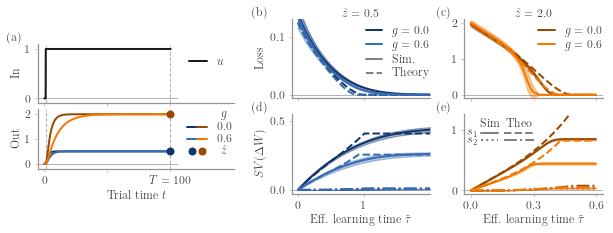

In [9]:
# Explain task and loss
fig = plt.figure(figsize=(fig_width, 0.5 * fig_height))
collapse=True

# Explain task
gs0 = GridSpec(2, 1)
# gs0.update(left=0.01, right=0.35, bottom=0.01, top=0.99, wspace=0.0, hspace=0.2)
gs0.update(left=0.01, right=0.35, bottom=0.15, top=0.85, wspace=0.0, hspace=0.1)
axes_explain = [plt.subplot(gs0[j, 0]) for j in range(2)]
plot_linear_explain(fig, axes_explain, task_explain_tas_gs, task_params_plt)

# Loss and SVs over training
gs0 = GridSpec(2, 2)
gs0.update(left=0.45, right=0.99, bottom=0.01, top=0.99, wspace=0.25, hspace=0.2)
axes_lzs = np.array([[plt.subplot(gs0[i, j]) for j in range(2)] for i in range(2)])
axes_loss = axes_lzs[0, :]
plot_loss(fig, axes_loss, target_amps, gs, idx_tas_plt, idx_gs_plt, 
          tls_all, losses_all, gs_theo, losses_theo_all, collapse=collapse)
axes_sv = axes_lzs[1, :]
plot_sv(fig, axes_sv, target_amps, gs, idx_tas_plt, idx_gs_plt, 
        tls_all, sv_dw_all, gs_theo, sv_dw_theo_all, collapse=collapse)

# Label plots
ypos = 1.
ax = fig.axes[0]
ax.text(-0.12, ypos, flbs[0], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)
ax_idxs = [2, 3, 4, 5]
for i, ax_idx in enumerate(ax_idxs):
    ax = fig.axes[ax_idx]
    if i%2==0:
        xpos = -0.23
    else:
        xpos = -0.15
    ax.text(xpos, ypos, flbs[i+1], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)
# Title
ax_idxs = [2, 3]
for i, ax_idx in enumerate(ax_idxs):
    ax = fig.axes[ax_idx]
    title = "$\hat{z} = %.1f$" % target_amps[idx_tas_plt[i]]
    ax.text(0.5, ypos, title, fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)


style.fixticks(fig)
if collapse:
    fig_name = "linear_explain_loss_sv_collapsed"
else:
    fig_name = "linear_explain_loss_sv"
if save_fig:
    style.saving_fig(fig, figure_path, fig_name, 'pdf')
    style.saving_fig(fig, figure_path, fig_name, 'png')
plt.show(fig)
plt.close(fig)

In [10]:
# Plot learning time
def plot_learning_time(fig, axes, target_amps, gs, idx_tas_plt, 
                       avg_grad_norms_all, norm_dw_last_all, tl_cs_all,
                       gs_theo, tl_cs_theo_all, 
                       normalize=True, invert_grad_norm=False,
                       landscape=False,
                       leg_z=True,
                       plot_samples=False,
                       plot_loss_shuffle=False,
                       c_theo='0.2',
                      ):
    if plot_loss_shuffle:
        ax0, ax1, ax2, ax3 = axes
    else:
        ax0, ax1, ax2 = axes

    for idx_j, j in enumerate(idx_tas_plt):
        c = cs[idx_j, 1]
        
        # Learning time
        tl_cs = tl_cs_all[:, j].copy()
        if normalize:
            tl_cs = tl_cs / tl_cs.mean(axis=0)[0]
        tl_cs_m = tl_cs.mean(axis=0)
        tl_cs_s = tl_cs.std(axis=0)
        if plot_loss_shuffle:
            ax0.plot(gs, tl_cs_m, 'o-', lw=lw, ms=ms, c=c)
        else:
            ax0.plot(gs, tl_cs_m, 'o-', lw=lw, ms=ms, c=c)#, label=r"$\hat{z} = %.1f$" % target_amp if leg_z else None)
        ax0.fill_between(gs, tl_cs_m - tl_cs_s, tl_cs_m + tl_cs_s, color=c, alpha=0.5)
        if plot_samples:
            for k in range(n_samples):
                ax0.plot(gs, tl_cs[k], '-', c=c, lw=0.5)
        # Target amplitude
        target_amp = target_amps[j]
        # Theory
        if not normalize:
            ax0.plot(gs_theo, tl_cs_theo_all[j, :, 2], '--', lw=lw, c=c)

        # Norm of dW at the end of training
        ndw = norm_dw_last_all[:, j]
        if normalize:
            ndw = ndw / ndw.mean(axis=0)[0]
        ndw_m = ndw.mean(axis=0)
        ndw_s = ndw.std(axis=0)
        ax1.plot(gs, ndw_m, 'o-', lw=lw, ms=ms, c=c)
        ax1.fill_between(gs, ndw_m - ndw_s, ndw_m + ndw_s, color=c, alpha=0.5)
        if plot_samples:
            for k in range(n_samples):
                ax1.plot(gs, ndw[k], '-', c=c, lw=0.5)
        
        # Average gradient norm
        if invert_grad_norm:
            agn = 1 / avg_grad_norms_all[:, j]
        else:
            agn = avg_grad_norms_all[:, j]
        if normalize:
            agn = agn / agn.mean(axis=0)[0]
        agn_m = agn.mean(axis=0)
        agn_s = agn.std(axis=0)
        ax2.plot(gs, agn_m, 'o-', lw=lw, ms=ms, c=c)
        ax2.fill_between(gs, agn_m - agn_s, agn_m + agn_s, color=c, alpha=0.5)
        if plot_samples:
            for k in range(n_samples):
                ax2.plot(gs, agn[k], '-', c=c, lw=0.5)
            
        # Loss after shuffling
        if plot_loss_shuffle:
            loss_shuff = loss_shuff_all[:, j].copy()
            # Normalize by loss at beginning of training
            loss_0 = target_amp**2 / 2
            loss_shuff /= loss_0
            loss_shuff_m = loss_shuff.mean(axis=0)
            loss_shuff_s = loss_shuff.std(axis=0)
            ax3.plot(gs, loss_shuff_m, 'o-', lw=lw, ms=ms, c=c)#, label=r"%.1f" % target_amp if leg_z else None)
            ax3.fill_between(gs, loss_shuff_m - loss_shuff_s, loss_shuff_m + loss_shuff_s, color=c, alpha=0.5)
            if plot_samples:
                for k in range(n_samples):
                    ax3.plot(gs, loss_shuff[k], '-', c=c, lw=0.5)

        # Legend
        target_amp = target_amps[j]
#         ax0.plot(0, 1, 'o-', lw=lw, ms=ms, c=c, label=r"$\hat{z} = %.1f$" % target_amp if leg_z else None)
        ax0.plot(0, 1, 'o-', lw=lw, ms=ms, c=c, label=r"%.1f" % target_amp if leg_z else None)
        
    if normalize:
        # Theory
        th1 = (1 - gs_theo**2)
        ax0.plot(gs_theo, th1**2, '--', lw=lw, c=c_theo, label="$(1 - g^2)^2$")
        ax1.plot(gs_theo, th1, '--', lw=lw, c=c_theo, label="$1 - g^2$")
        if invert_grad_norm:
            ax2.plot(gs_theo, th1, '--', lw=lw, c=c_theo, label="$1 - g^2$")
        else:
            ax2.plot(gs_theo, 1/th1, '--', lw=lw, c=c_theo, label="$1 / (1 - g^2)$")
            ax2.set_ylim(-0.25, 6.5)
        
    loss_shuff_theo = lambda g: g**4 * (2 - g**2)**2
    ax3.plot(gs_theo, loss_shuff_theo(gs_theo), '--', lw=lw, c=c_theo, label="$g^4(2 - g^2)^2$")

    # Legend
    for ax in axes:
        ax.axhline(0, ls='-', c='0.7', zorder=-1)
        ax.set_ylim(-0.05, None)
        if invert_grad_norm:
            ax.legend(loc=3, ncol=1, frameon=False, handlelength=1.4, labelspacing=0.1, markerscale=1)
    if not invert_grad_norm:
        if normalize:
            leg = ax0.legend(loc=3, ncol=1, frameon=False, handlelength=1.3, 
                             handletextpad=0.4,
                             title=r"$\hat{z}\,\,$", title_fontsize=fs,
                             labelspacing=0.1, markerscale=1)
            leg.get_title().set_position((-6, 0))
            if plot_loss_shuffle:
                # Move legend down
                ax=ax0
                bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
                xOffset = -0.07
                bb.x0 += xOffset
                bb.x1 += xOffset
                leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
        else:
            ax0.legend(loc=1, ncol=1, frameon=False, handlelength=1.4, labelspacing=0.1, markerscale=1)
        ax1.legend(loc=3, ncol=1, frameon=False, handlelength=1.4, labelspacing=0.1, markerscale=1)
        ax2.legend(loc=2, ncol=1, frameon=False, handlelength=1.2, labelspacing=0.1, markerscale=1)
    if plot_loss_shuffle:
        ax3.legend(loc=2, ncol=1, frameon=False, handlelength=1.2, labelspacing=0.1, markerscale=1, handletextpad=0.4)
        ax3.set_yticks([0, 1])
        ax3.set_yticklabels([0, "$L_0$"])
        
        
        
    ax0.set_ylabel("Conv. time")
    ax1.set_ylabel(r"$|| \Delta W ||$")
    ax2.set_ylabel(r"Avg. grad.")
    if plot_loss_shuffle:
        ax3.set_ylabel(r"Loss after shuffle", labelpad=0)
        

    if normalize:
        if invert_grad_norm:
            ax2.set_yticks([0, 1])
        if not invert_grad_norm:
            ax2.set_ylim(-0.3, 6.3)
        ax0.set_yticks([0, 1])
        ax1.set_yticks([0, 1])

    for i, ax in enumerate(axes):
        ax.set_xlim(-0.05, 1.05)
        ax.set_xticks([0, 0.5, 1])
        if not (landscape or i == 2):
            ax.set_xticklabels([])



Save figure to ../../tex/neurips_2020/submission_2/figures\linear_learning_time_normalized_loss_shuff.pdf
Save figure to ../../tex/neurips_2020/submission_2/figures\linear_learning_time_normalized_loss_shuff.png


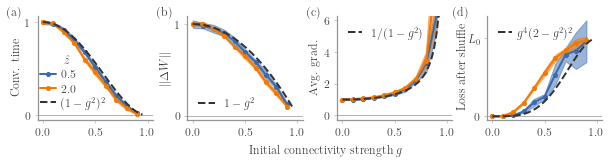

In [11]:
# Learning time and shuffle loss

normalize = True
nax = 4
fig = plt.figure(figsize=(fig_width, 0.3 * fig_height))
gs0 = GridSpec(1, nax)
gs0.update(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.3, hspace=0.0)
axes_lt = [plt.subplot(gs0[0, j]) for j in range(nax)]
plot_learning_time(fig, axes_lt, target_amps, gs, idx_tas_plt, 
                   avg_grad_norms_all, norm_dw_last_all, tl_cs_all,
                   gs_theo, tl_cs_theo_all, 
                   normalize=normalize, 
                   invert_grad_norm=False,
                   landscape=True, 
                   plot_samples=False,
                   plot_loss_shuffle=True,
                  )

ypos = 0.97
ax_idxs = np.arange(nax-1)
for i, ax_idx in enumerate(ax_idxs):
    ax = fig.axes[ax_idx]
    ax.text(-0.2, ypos, flbs[i], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)
ax = fig.axes[3]
ax.text(-0.23, ypos, flbs[3], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)

ax = fig.axes[1]
ax.text(1.2, -0.35, "Initial connectivity strength $g$", fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)


style.fixticks(fig)
fig_name = "linear_learning_time"
if normalize:
    fig_name += "_normalized"
fig_name += "_loss_shuff"
if save_fig:
    style.saving_fig(fig, figure_path, fig_name, 'pdf')
    style.saving_fig(fig, figure_path, fig_name, 'png')
plt.show(fig)
plt.close(fig)

Save figure to ../../tex/neurips_2020/submission_2/figures\linear_loss_sv_log.pdf
Save figure to ../../tex/neurips_2020/submission_2/figures\linear_loss_sv_log.png


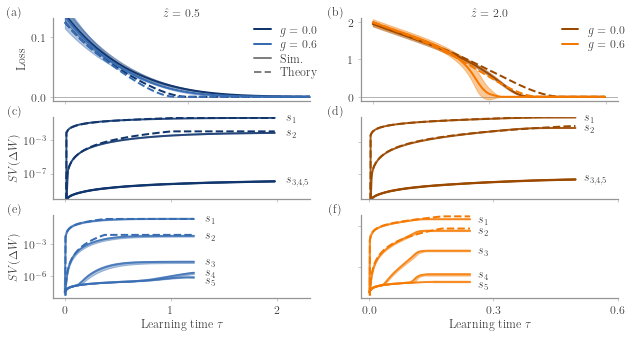

In [12]:
# Singular values on log scale

def plot_sv_log(fig, axes, target_amps, gs, idx_tas_plt, idx_gs_plt, 
                tls_all, sv_dw_all, gs_theo, sv_dw_theo_all):

    for idx_j, j in enumerate(idx_tas_plt):

        # Target amplitude
        target_amp = target_amps[j]

        # Max range to plot
        xlim = [2.2, 0.4][idx_j]
        tls_max = [2.0, 0.5][idx_j]

        for idx_i, i in enumerate(idx_gs_plt):
            ax1 = axes[idx_i, idx_j]

            c = cs[idx_j, idx_i]
            g = gs[i]
            tls = tls_all[j, i]

            itl = np.argmin((tls - tls_max)**2)
            tls = tls[:itl]

            # SVs
            lss = ['-', ':']
            ls = lss[0]
            n_plt_sim = 5
            for idx in range(n_plt_sim):
                sv = sv_dw_all[:, j, i, :, idx]

                sv = sv[:, :itl]

                svm = sv.mean(axis=0)
                svs = sv.std(axis=0)

                ax1.plot(tls, svm, ls, lw=lw,  c=c, alpha=0.8)
                ax1.fill_between(tls, svm - svs, svm + svs, color=c, alpha=0.4)

                # Label
                dx = xlim * 0.05
                ypos = svm[-1]
                if g == 0 and idx == 2:
                    ax1.text(tls[-1] + dx, ypos, '$s_{3, 4, 5}$', fontsize=fs, ha='left', va='center')
                elif g == 0 and idx > 2:
                    pass
                elif g > 0 and idx == 4:
                    ypos *= 0.5
                    ax1.text(tls[-1] + dx, ypos, '$s_%d$' % (idx+1), fontsize=fs, ha='left', va='center')
                else:
                    ax1.text(tls[-1] + dx, ypos, '$s_%d$' % (idx+1), fontsize=fs, ha='left', va='center')


            # Theory (plot only 3rd order)
            it = np.argmin((gs_theo - g)**2)
            ax1.plot(tls, sv_dw_theo_all[j, it, 2, :itl], '--', lw=lw, c=c)
            ax1.plot(tls, sv_dw_theo_all[j, it, 3, :itl], '--', lw=lw, c=c)

            # y axis
            ax1.set_yscale('log')
            ylim = sv_dw_all[:, j].max() * 1.1
            ymin = [1e-10, 1e-8][idx_i]
            ax1.set_ylim(ymin * 0.95, 1.05 * ylim)
            if idx_j == 0:
                ax1.set_ylabel(r"$SV(\Delta W)$")
            else:
                ax1.set_yticklabels([])

            # x axis
            ax1.set_xlim(-0.05 * xlim, 1.05 * xlim)

            xticks = [[0, 1, 2], [0, 0.3, 0.6]][idx_j]
            ax1.set_xticks(xticks)
            if idx_i ==0:
                ax1.set_xticklabels([])
            else:
                ax1.set_xlabel(r"Learning time $\tau$")


fig = plt.figure(figsize=(fig_width, 0.8 * fig_height))

# Loss and SVs over training
gs0 = GridSpec(3, 2)
gs0.update(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.2, hspace=0.2)
axes_lzs = np.array([[plt.subplot(gs0[i, j]) for j in range(2)] for i in range(3)])
axes_loss = axes_lzs[0, :]
plot_loss(fig, axes_loss, target_amps, gs, idx_tas_plt, idx_gs_plt, 
          tls_all, losses_all, gs_theo, losses_theo_all)
axes_sv = axes_lzs[1:, :]
plot_sv_log(fig, axes_sv, target_amps, gs, idx_tas_plt, idx_gs_plt, 
        tls_all, sv_dw_all, gs_theo, sv_dw_theo_all)
    
    
# Label plots
ypos = 1.
ax_idxs = np.arange(6)
for i, ax_idx in enumerate(ax_idxs):
    ax = fig.axes[ax_idx]
    if i%2==0:
        xpos = -0.15
    else:
        xpos = -0.1
    ax.text(xpos, ypos, flbs[i], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)
# Title
ax_idxs = [0, 1]
for i, ax_idx in enumerate(ax_idxs):
    ax = fig.axes[ax_idx]
    title = "$\hat{z} = %.1f$" % target_amps[idx_tas_plt[i]]
    ax.text(0.5, ypos, title, fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)
    
    
style.fixticks(fig)
fig_name = "linear_loss_sv_log"
if save_fig:
    style.saving_fig(fig, figure_path, fig_name, 'pdf')
    style.saving_fig(fig, figure_path, fig_name, 'png')
plt.show(fig)
plt.close(fig)

# Failure of learning due to too large target

In [13]:
# Load data
# data_file_name = "linear_zhats_gs_N_1024_tmax_101"
data_file_name = "linear_diverge_zhats_gs_N_256_tmax_201"

data_file_name += ".pkl"
data_file = os.path.join(data_dir, data_file_name)
print("data_file_name:\n", data_file_name)
with open(data_file, 'rb') as handle:
    res_dict = pickle.load(handle)
print("Loaded data from " + data_file)

dims = res_dict["dims"]
dt = res_dict["dt"]
noise_std = res_dict["noise_std"]
n_epochs = res_dict["n_epochs"]
rec_step = res_dict["rec_step"]
epochs = res_dict["epochs"]
rec_epochs = res_dict["rec_epochs"]
gs = res_dict["gs"]
target_amps = res_dict["target_amps"]
lr0s = res_dict["lr0s"]
n_gs = res_dict["n_gs"]
n_tas = res_dict["n_tas"]
n_samples = res_dict["n_samples"]
lrs_all = res_dict["lrs_all"]
tls_all = res_dict["tls_all"]
task_params_all = res_dict["task_params_all"]
wi_init_all = res_dict["wi_init_all"]
wo_init_all = res_dict["wo_init_all"]
wrec_init_all = res_dict["wrec_init_all"]
dwrec_last_all = res_dict["dwrec_last_all"]
losses_all = res_dict["losses_all"]
grad_norms_all = res_dict["grad_norms_all"]
loss_shuff_all = res_dict["loss_shuff_all"]
ev_w_all = res_dict["ev_w_all"]
sv_dw_all = res_dict["sv_dw_all"]
zs_all = res_dict["zs_all"]
time_t = res_dict["time_t"]
time_ev = res_dict["time_ev"]
time_sv = res_dict["time_sv"]
time_ls = res_dict["time_ls"]
    
dim_in, dim_rec, dim_out = dims

data_file_name:
 linear_diverge_zhats_gs_N_256_tmax_201.pkl
Loaded data from ..\..\data\neurips_2020\linear_diverge_zhats_gs_N_256_tmax_201.pkl


In [14]:
#########################################################################################3
# Analytical theory
# Cut theory at z - z_hat ?
cut_theo = True

# Compute analytical theory for a dense array for gs
# assert gs[0] == 0
g_theo_max = 0.95
dg_theo = 0.01
gs_theo = np.arange(0, g_theo_max+dg_theo, dg_theo)
n_gs_theo = len(gs_theo)

tls_theo_all = np.zeros((n_tas, n_gs_theo, n_epochs))
zs_theo_all = np.zeros((n_tas, n_gs_theo, 3, n_epochs))
losses_theo_all = np.zeros((n_tas, n_gs_theo, 3, n_epochs))
tl_cs_theo_all = np.zeros((n_tas, n_gs_theo, 3))
sv_dw_theo_all = np.zeros((n_tas, n_gs_theo, 4, n_epochs))
ev_w_theo_all = np.zeros((n_tas, n_gs_theo, 2, n_epochs))
ev_dw_theo_all = np.zeros((n_tas, n_gs_theo, 2, n_epochs))

for j, target_amp in enumerate(target_amps):
    lr0 = lr0s[j]

    for i, g in enumerate(gs_theo):
        # Times
        lr = lr0 * (1 - g**2)**2
        tls = epochs * lr

        # Coefficients
        z_hat = target_amp
        beta = 1 / (1 - g**2)
        gamma = beta**4

        a_1 = tls**(1/2) * z_hat**(1/2)
        a_2 = -1/4 * tls**(3/2) * z_hat**(1/2) * beta**2
        a_3 = 5/96 * tls**(5/2) * z_hat**(1/2) * beta**4
        b_2 = 1/2 * tls**(3/2) * z_hat**(3/2) * beta
        b_3 = -1/4 * tls**(5/2) * z_hat**(3/2) * beta**3
        c_3 = 1/6 * tls**(5/2) * z_hat**(5/2) * beta**2
        b_hat_2 = np.sqrt(1/12) * tls**(3/2) * z_hat**(3/2) * beta

        # Readout
        tlsb = beta**2 * tls
        z_1 = z_hat * tlsb
        z_2 = -z_hat * tlsb**2 / 2
        z_3 = z_hat * tlsb**3 / 6 * (1 + 8 * z_hat**2 * beta)
        zs_theo = np.array([z_1, z_1 + z_2, z_1 + z_2 + z_3])
        # Singular values
        s_1 = z_hat / beta * tlsb
        s_2 = -z_hat / beta * tlsb**2 / 2
        s_3 = z_hat / beta * tlsb**3 / 6 * (1 + 7/2 * z_hat**2 * beta)
        sv_dw_theo_1 = s_1
        sv_dw_theo_2 = s_1 + s_2
        sv_dw_theo_3p = s_1 + s_2 + s_3
        sv_dw_theo_3m = z_hat**3 * tlsb**3 / 12

        # Eigenvalues
        # Eigenvalue of dW alone
        ev_dw_theo_2 = 2 * a_1 * b_2 * beta**2
        # ev_w_theo_2a = g**2 + 1/2 * (ev_dw_theo_2 + np.sqrt(ev_dw_theo_2**2 + 4 * ev_dw_theo_2 * g**2))
        # # The approximation is actually order t!
        ev_w_theo_2 = g**2 + g * np.sqrt(ev_dw_theo_2) + 1/2 * ev_dw_theo_2
        # Order t^3
        ev_dw_theo_3 = 2 * (a_1 * b_2 + a_2 * b_2 + a_1 * b_3) * beta**2
        ev_w_theo_3 = g**2 + 1/2 * (ev_dw_theo_3 + np.sqrt(ev_dw_theo_3**2 + 4 * ev_dw_theo_3 * g**2))

        # Join
        sv_dw_theo = np.c_[sv_dw_theo_1, sv_dw_theo_2, sv_dw_theo_3p, sv_dw_theo_3m].T
        ev_w_theo = np.c_[ev_w_theo_2, ev_w_theo_3].T
        ev_dw_theo = np.c_[ev_dw_theo_2, ev_dw_theo_3].T
        
        # Loss
        losses_theo = 0.5 * (z_hat - zs_theo)**2
        # Learning time
        loss_0 = target_amp**2 / 2
        loss_c = 0.001 * loss_0
        tl_cs_theo = tls[np.argmax(losses_theo < loss_c, axis=-1)]

        # Cut theory at z - z_hat
        if cut_theo:
            idx_learn = np.array([np.argmax(zs_theo[idx] > z_hat) for idx in range(3)])
            t_learn = np.array([epochs[idx] for idx in idx_learn])
            t_learn = np.where(t_learn == 0, epochs[-1], t_learn)
            mask = epochs[None, :] <= t_learn[:, None]

            zs_theo = np.where(mask, zs_theo, z_hat)
            losses_theo = np.where(mask, losses_theo, 0)
            for idx in range(4):
                im = [0, 1, 2, 2][idx]
                sv_dw_theo[idx] = np.where(mask[im], sv_dw_theo[idx], sv_dw_theo[idx, idx_learn[im]])
            for idx in range(2):
                im = [1, 2][idx]
                ev_dw_theo[idx] = np.where(mask[im], ev_dw_theo[idx], ev_dw_theo[idx, idx_learn[im]])
                ev_w_theo[idx] = np.where(mask[im], ev_w_theo[idx], ev_w_theo[idx, idx_learn[im]])

        # Save
        tls_theo_all[j, i] = tls
        losses_theo_all[j, i] = losses_theo
        zs_theo_all[j, i] = zs_theo
        sv_dw_theo_all[j, i] = sv_dw_theo
        ev_dw_theo_all[j, i] = ev_dw_theo
        ev_w_theo_all[j, i] = ev_w_theo
        tl_cs_theo_all[j, i] = tl_cs_theo


In [15]:
# Plot specs

# Line width and marker size
lw=2
ms=4

idx_sample = 0

idx_tas_plt = np.array([0, 1])
idx_gs_plt = np.array([0, 1])

Save figure to ../../tex/neurips_2020/submission_2/figures\linear_failed_learning.pdf
Save figure to ../../tex/neurips_2020/submission_2/figures\linear_failed_learning.png


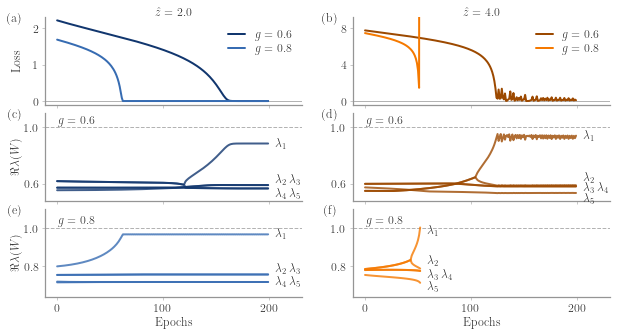

In [16]:
# Singular values on log scale
xlims = [220, 220]

def plot_fail_learn(fig, axes, target_amps, gs, idx_tas_plt, idx_gs_plt, 
                tls_all, losses_all, ev_w_all, gs_theo, ev_w_theo_all, idx_sample=0):

    for idx_j, j in enumerate(idx_tas_plt):
        axes_j = axes[:, idx_j]
        ax0, _, _ = axes_j
        # Target amplitude
        target_amp = target_amps[j]
        
        
        # Max range to plot
        xlim = xlims[j]
        
        for idx_i, i in enumerate(idx_gs_plt):
            c = cs[idx_j, idx_i]
            g = gs[i]
            tls = epochs
            if target_amp == 2.: 
                idx_sample = 0
            if target_amp == 4.: 
                if g == 0.6:
                    idx_sample = 2
                else:
                    idx_sample = 0
                
            # Loss
            ax0.plot(tls, losses_all[idx_sample, j, i], '-', c=c, lw=lw)

            # EVs
            ax1 = axes_j[1:][idx_i]
            lss = ['-', ':']
            ls = lss[0]
            n_plt_sim = 5
            for idx in range(n_plt_sim):
                ev_i = ev_w_all[idx_sample, j, i, :, idx].real
                tls_i = tls.copy()
                if (ev_i == 0).any():
                    i_nan = np.argmax(ev_i == 0.) 
                    ev_i = ev_i[:i_nan]
                    tls_i = tls_i[:i_nan]
                    
                ax1.plot(tls_i, ev_i, ls, lw=lw,  c=c, alpha=0.8)

                # Label
                dx = xlim * 0.06
                xpos = tls_i[-1] + dx/2
                ypos = ev_i[-1]
                
                # fine-tune
                if idx>0 and idx%2==0:
                    if not (target_amp == 4.):
                        xpos += dx
                if g == 0.6 and target_amp == 2.:
                    dy = 0.035
                    if idx in [1, 2]:
                        ypos += dy
                    elif idx in [3, 4]:
                        ypos -= dy
                if g == 0.8 and target_amp == 2.:
                    dy = 0.03
                    if idx in [1, 2]:
                        ypos += dy
                if g == 0.6 and target_amp == 4.:
                    if idx == 3:
                        xpos += dx
                    if idx in [1]:
                        dy = 0.05
                        ypos += dy
                    elif idx in [2, 3]:
                        dy = 0.01
                        ypos -= dy
                    elif idx in [4]:
                        dy = 0.04
                        ypos -= dy
                if g == 0.8 and target_amp == 4.:
                    if idx == 3:
                        xpos += dx
                    if idx == 1:
                        dy = 0.04
                        ypos += dy
                    elif idx in [0, 2, 3, 4]:
                        dy = 0.02
                        ypos -= dy
                        
                ax1.text(xpos, ypos, r'$\lambda_%d$' % (idx+1), fontsize=fs, ha='left', va='center')
                
#             # Theory
#             it = np.argmin((gs_theo - g)**2)
#             ax0.plot(tls, losses_theo_all[j, it, 2], '--', c=c, lw=lw)
#             ax1.plot(tls, ev_w_theo_all[j, it, 1], '--', lw=lw, c=c)

            # y axis
            if idx_j == 0:
                ax1.set_ylabel(r"$\Re \lambda(W)$", labelpad=2)
                
            # Lines
            ax1.axhline(1, ls='--', c='0.7', zorder=-1)
            ax1.set_ylim(0.8 * g, 1.1)
            ax1.set_yticks([g, 1])

            # Label
            if g == 0.6:
                ax1.text(0.05, 0.85, "$g = %.1f$" % g, fontsize=fs, ha='left', va='bottom', transform=ax1.transAxes)
            else:
                ax1.text(0.05, 0.8, "$g = %.1f$" % g, fontsize=fs, ha='left', va='bottom', transform=ax1.transAxes)
                
        # Legend
        for idx_i, i in enumerate(idx_gs_plt):
            c = cs[idx_j, idx_i]
            ax0.plot(0, 0, lw=lw, c=c, label="$g=%.1f$" % gs[i])
        ax0.legend(loc=1, ncol=1, frameon=False, handlelength=1.4, labelspacing=0.1)
            
        # Lines
        ax0.axhline(0, ls='-', c='0.7', zorder=-1)
        # y axis
        loss_0 = target_amp**2 / 2
        ylim = loss_0
        ax0.set_ylim(-0.05 * ylim, 1.15 * ylim)
        if idx_j == 0:
            ax0.set_ylabel("Loss", labelpad=10)
        yticks = [0, loss_0//2, loss_0]
        ax0.set_yticks(yticks)
        # x axis
        xticks = [[0, 100, 200], [0, 100, 200]][idx_j]
        for i, ax in enumerate(axes_j):
            ax.set_xlim(-0.05 * xlim, 1.05 * xlim)
            ax.set_xticks(xticks)
            if i == 2:
                ax.set_xlabel(r"Epochs")
            else:
                ax.set_xticklabels([])

##################################################################################3
fig = plt.figure(figsize=(fig_width, 0.8 * fig_height))
gs0 = GridSpec(3, 2)
gs0.update(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.2, hspace=0.1)
axes = np.array([[plt.subplot(gs0[i, j]) for j in range(2)] for i in range(3)])
plot_fail_learn(fig, axes, target_amps, gs, idx_tas_plt, idx_gs_plt, 
        tls_all, losses_all, ev_w_all, gs_theo, ev_w_theo_all, idx_sample=idx_sample)

# Label plots
ypos = 0.92
ax_idxs = np.arange(6)
for i, ax_idx in enumerate(ax_idxs):
    ax = fig.axes[ax_idx]
    if i%2==0:
        xpos = -0.12
    else:
        xpos = -0.09
    ax.text(xpos, ypos, flbs[i], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)
# Title
ax_idxs = [0, 1]
for i, ax_idx in enumerate(ax_idxs):
    ax = fig.axes[ax_idx]
    title = "$\hat{z} = %.1f$" % target_amps[idx_tas_plt[i]]
    ax.text(0.5, 1., title, fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)
    
style.fixticks(fig)
fig_name = "linear_failed_learning"
if save_fig:
    style.saving_fig(fig, figure_path, fig_name, 'pdf')
    style.saving_fig(fig, figure_path, fig_name, 'png')
plt.show(fig)
plt.close(fig)